In [ ]:
import os
import numpy as np
import matplotlib
import torch
# !pip install mat73
# import mat73
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torchvision import transforms, utils
import time
import pandas as pd
import scipy.io
import sklearn.metrics
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

from scipy import signal

from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import LeaveOneGroupOut






In [ ]:
Folder='model_all_vit/v1_per8_trans_result/'
#Folder='model_all_CNN/trans_result/'
def plotfigFullClass(cm,acc,tle,saveN):

    parent_dir = r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+'/'
    path1 = os.path.join(parent_dir, 'cm_fig')
    os.makedirs(path1, exist_ok = True) 
    path1 = os.path.join(parent_dir, 'result_all')
    os.makedirs(path1, exist_ok = True) 

    
    name1=["R", "G","Gx2","P1","P1x2","P2","P2x2","P23","P23x2","P4","P4x2","sG","sF","sP1","sP2","sP23","sP4","U","Ux2","D","Dx2","sU","sD"]
    name2=name1
    w=20 #fig size 1      change when label num change
    h=22   #fig size 2
    

    cm=cm*100
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
 
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    mask = np.zeros_like(df_cm)
    mask[np.where(cm==0)] = True
    plt.rcParams.update({'axes.facecolor':'whitesmoke'})

    res=sn.heatmap(df_cm, cmap="YlGnBu",fmt=".1f",vmin=0, vmax=100,annot=True,mask=mask,square=True,cbar=False,annot_kws={"size": 18},xticklabels=name1,yticklabels=name1)
 
    sz=22
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = sz)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = sz) 

    s01='Overall accuracy = {n:.1f} % '.format(n=acc*100)
    #plt.text(a,b,s01,fontsize=size)
    
    
    plt.title(tle+s01,fontsize = sz+2)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    
    plt.savefig(parent_dir+r"cm_fig/"+saveN+".png", dpi=600)

# plotfigFullClass(cm_norm_max_mean_th,acc_max_mean,'','fig_final_per8_trans_'+str(k)+'fold')


In [ ]:
# load saved tested results for all participants

Folder='model_all_CNN/trans_result/'
from google.colab import drive
drive.mount('/content/drive')
in_ch=48


def loadResult(k_split,FeatVer,transOpt):
  cm_all_per=[]
  acc_all_per=[]
  test_y_all_per=[]
  feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
  for per in range(1,9):
    Path=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+str(per)+"/npyFile/"+'ch'+str(in_ch)+'_'+str(k_split)+'fold_'+feature_listName[FeatVer]+'_trans_'+str(transOpt)+'.npz'
    data=np.load(Path,allow_pickle=True)
    cm=data['cm_norm']
    #acc_all=data['acc_all']
    acc=data['acc']
    test_y=data['test_y']
    test_ind=data['test_ind']

    cm_all_per.append(cm)
    acc_all_per.append(acc)
    test_y_all_per.append(test_y)
    
  acc_all_per=np.array(acc_all_per)
  acc_mean=np.mean(acc_all_per)
  cm_all_per=np.array(cm_all_per)
  print(acc_mean)
   
  return cm_all_per,acc_all_per,acc_mean,test_y_all_per


# choose 1/n as new data k fold 
k=5


## load all feat ver. results 
cm_norm_all=[[],[],[],[],[]]
acc_all=[[],[],[],[],[]]
acc_mean=[[],[],[],[],[]]
test_y_all=[[],[],[],[],[]]
trans_opt=1
for i in range(0,5):
  cm_norm_all[i],acc_all[i],acc_mean[i],test_y_all[i]=loadResult(k,i,trans_opt)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.8939372213570695
0.9072577749086502
0.9003262480398746
0.9008390786210413
0.9038933231826833


In [ ]:



## output ensemble result and output the final max accuracy, the highest or ensemble 

def ensemble_y(test_y_all):
  test_y1=test_y_all[0]
  y_ensemble=np.zeros([np.size(test_y1,axis=1),])
  for i in range(np.size(test_y1,axis=1)):
    
    list=[]
    for j in range(len(test_y_all)):

      list.append(test_y_all[j][1,i])  ## append different feat ver. 
    
    (unique, counts) = np.unique(list, return_counts=True)

    label=unique[np.argmax(counts)]
    y_ensemble[i]=label


  cm_norm=confusion_matrix(test_y1[0,:], y_ensemble,normalize='true')
  acc=accuracy_score(test_y1[0,:], y_ensemble)
  
   

  return cm_norm,acc,y_ensemble

cm_norm_en=[]
y_ensemble_en=[]
acc_en=[]
cm_norm_max=[]

acc_max=[]
max_Featver=[]  
for i in range(8):
  # use 5 FeatVer to ensemble
  test_y_per=[test_y_all[0][i],test_y_all[1][i],test_y_all[2][i],test_y_all[3][i],test_y_all[4][i]]
  # only use stft2,cwt2,cwt3 
  #test_y_per=[test_y_all[1][i],test_y_all[3][i],test_y_all[4][i]]

  cm_t,acc_t,y_ensemble_t=ensemble_y(test_y_per)
  cm_norm_en.append(cm_t)
  acc_en.append(acc_t)
  y_ensemble_en.append(y_ensemble_t)
  
  feature_listName=["stft","stft2","cwt","cwt2","cwt3",'en']
  acc_comp=[acc_all[0][i],acc_all[1][i],acc_all[2][i],acc_all[3][i],acc_all[4][i],acc_en[i]]
  cm_comp=[cm_norm_all[0][i],cm_norm_all[1][i],cm_norm_all[2][i],cm_norm_all[3][i],cm_norm_all[4][i],cm_norm_en[i]]
  acc_max.append(acc_comp[np.argmax(acc_comp)])
  cm_norm_max.append(cm_comp[np.argmax(acc_comp)])
  max_Featver.append(feature_listName[np.argmax(acc_comp)])



cm_norm_max=np.array(cm_norm_max)
cm_norm_max_mean=np.mean(cm_norm_max,axis=0)
cm_norm_max_mean_th=np.where(cm_norm_max_mean > 0.007, cm_norm_max_mean, 0)
print(cm_norm_max_mean_th)
acc_max_mean=np.mean(acc_max)

SaveName='result_all_max_'+str(k)+'fold'+'_trans'+str(trans_opt)+'_per8'
#SaveName='result_all_max_'+str(k)+'fold'+'_trans'+str(trans_opt)+'_per8'+'_cnn'
np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+"result_all/"+SaveName+".npz",\
                    cm_norm_all=cm_norm_all,acc_all=acc_all,\
                    acc_mean=acc_mean,acc_max_mean=acc_max_mean,cm_norm_max_mean_th=cm_norm_max_mean_th,\
                   acc_max=acc_max,cm_norm_max=cm_norm_max,max_Featver=max_Featver)

from scipy.io import savemat
    
savemat("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+"result_all/"+SaveName+".mat",\
                    {'cm_norm_all':cm_norm_all,'acc_all':acc_all,\
                      'acc_max_mean':acc_max_mean,'cm_norm_max_mean_th':cm_norm_max_mean_th,\
                   'acc_max':acc_max,'cm_norm_max':cm_norm_max,'max_Featver':max_Featver})



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.8867518219699837


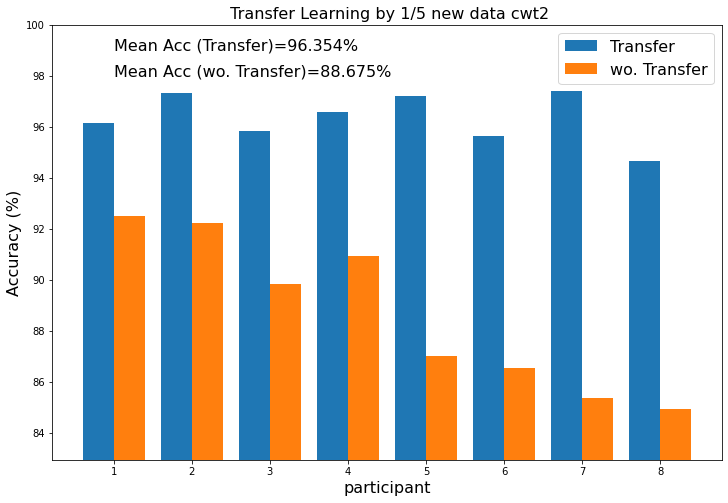

In [ ]:
# plop one featVer result 
k=5
FeatVer=3
feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
acc1=np.array(acc_all[FeatVer])
_,acc2,_,_=loadResult(k,FeatVer,0)


bar_width = 0.4
sz=16
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(acc1))+1 -bar_width/2

# Define bar width. We'll use this to offset the second bar.


# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, acc1*100,width=bar_width,label='Transfer')
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + bar_width, acc2*100,width=bar_width,label='wo. Transfer')
plt.legend(fontsize=sz)
plt.ylim(np.amin(acc2)*100-2, 100)
plt.rcParams["font.family"] = "Times New Roman"

axis_font={'fontname':'Times New Roman', 'size':str(sz)}

plt.xlabel('participant',axis_font)
plt.ylabel('Accuracy (%)',axis_font)

plt.title(" Transfer Learning by 1/"+str(k)+' new data '+feature_listName[FeatVer],axis_font)
s01='Mean Acc (Transfer)={n:.3f}%'.format(n=np.mean(acc1)*100)
s02='Mean Acc (wo. Transfer)={n:.3f}%'.format(n=np.mean(acc2)*100)
plt.text(1,99,s01,axis_font)
plt.text(1,98,s02,axis_font)

tleSave=str(k)+'fold_all_w_wo trans'+'_'+feature_listName[FeatVer]
saveFigPath=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+'/'
plt.savefig(saveFigPath+r"fig_all/"+tleSave+".png", dpi=300)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.8867518219699837


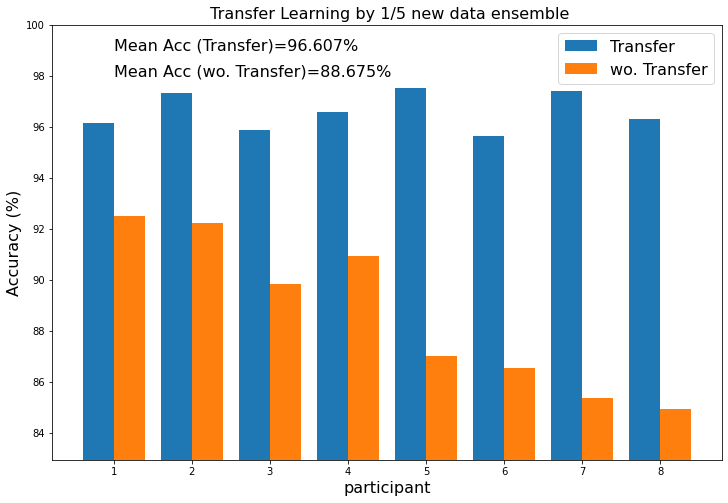

In [ ]:
# plot ensemble result accuracy highest 
k=5
FeatVer=3
feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
acc1=np.array(acc_max)
_,acc2,_,_=loadResult(k,FeatVer,0)


bar_width = 0.4
sz=16
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(acc1))+1 -bar_width/2

# Define bar width. We'll use this to offset the second bar.


# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, acc1*100,width=bar_width,label='Transfer')
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + bar_width, acc2*100,width=bar_width,label='wo. Transfer')
plt.legend(fontsize=sz)
plt.ylim(np.amin(acc2)*100-2, 100)
plt.rcParams["font.family"] = "Times New Roman"

axis_font={'fontname':'Times New Roman', 'size':str(sz)}

plt.xlabel('participant',axis_font)
plt.ylabel('Accuracy (%)',axis_font)

plt.title(" Transfer Learning by 1/"+str(k)+' new data'+' ensemble',axis_font)
s01='Mean Acc (Transfer)={n:.3f}%'.format(n=np.mean(acc1)*100)
s02='Mean Acc (wo. Transfer)={n:.3f}%'.format(n=np.mean(acc2)*100)
plt.text(1,99,s01,axis_font)
plt.text(1,98,s02,axis_font)

tleSave=str(k)+'fold_all_w_wo trans'+'_'+'max'
saveFigPath=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+Folder+'/'
plt.savefig(saveFigPath+r"fig_all/"+tleSave+".png", dpi=300)

[[0.97525778 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.97070528 0.         0.         0.         0.
  0.         0.         0.         0.01722112 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.9669179  0.         0.         0.
  0.         0.         0.         0.         0.0202333  0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.9655943  0.01460627 0.01075688
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.   

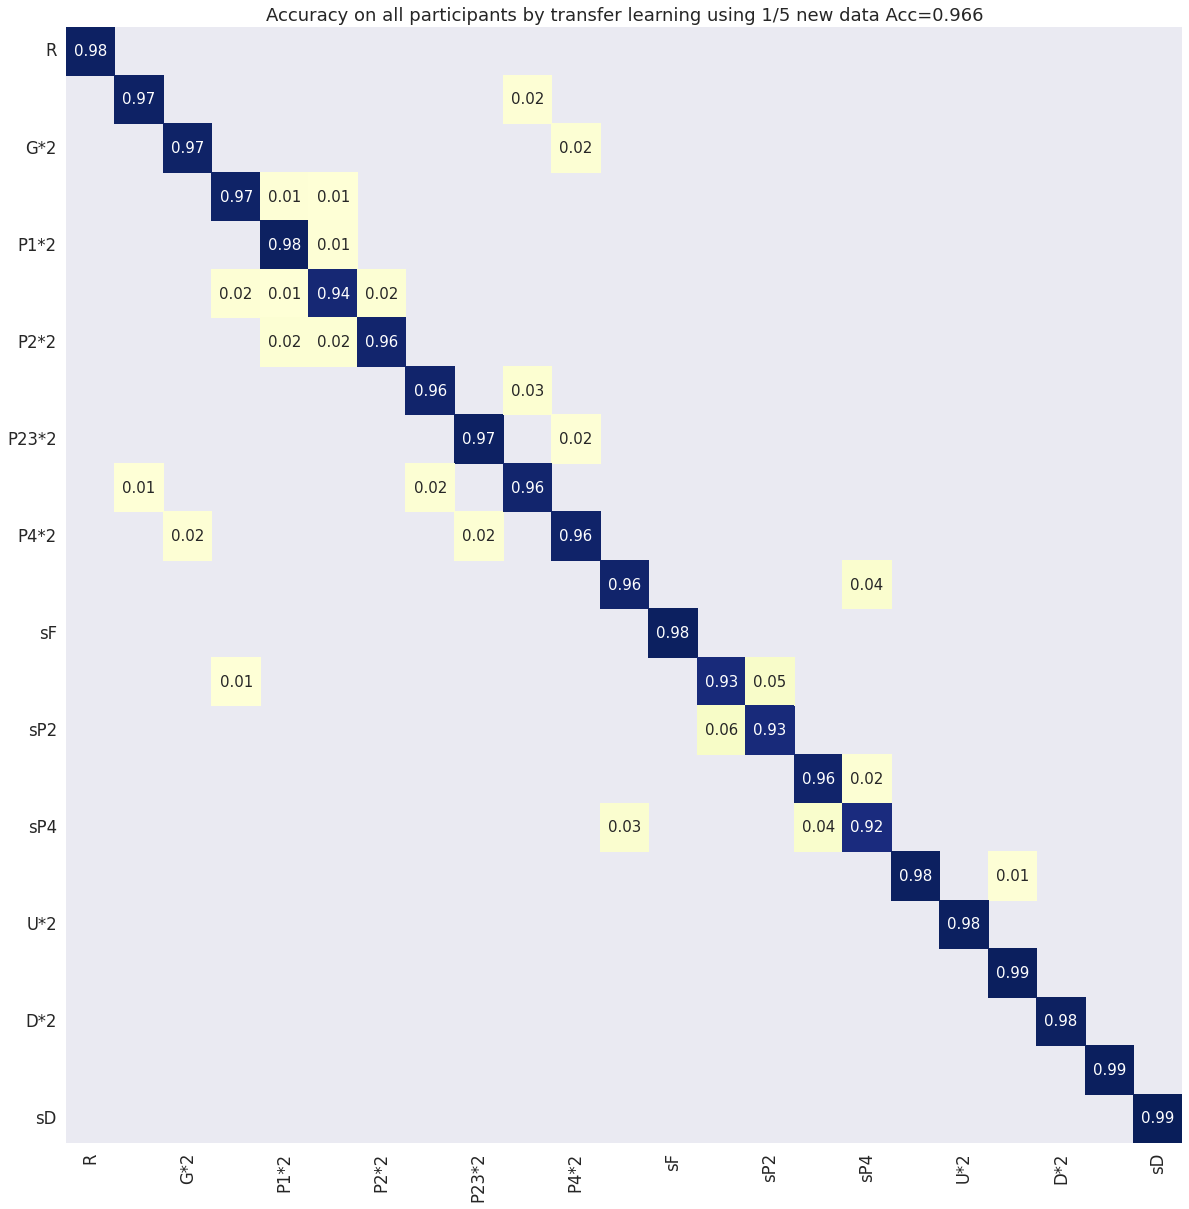

In [ ]:


# average confusion matrix on all participants
# and output fig 
cm_norm_max=np.array(cm_norm_max)
cm_norm_max_mean=np.mean(cm_norm_max,axis=0)
cm_norm_max_mean_th=np.where(cm_norm_max_mean > 0.01, cm_norm_max_mean, 0)
print(cm_norm_max_mean_th)
acc_max_mean=np.mean(acc_max)#Accuracy on all participants by transfer learning using 1/5 new data
plotfigFullClass(cm_norm_max_mean_th,acc_max_mean,'Accuracy on all participants by transfer learning using 1/5 new data','all')


In [ ]:
print(acc_en)
print(acc_max)

[0.9418604651162791, 0.9592088998763906, 0.9462397179788484, 0.9319899244332494, 0.9653179190751445, 0.9222383720930233, 0.9630847953216374, 0.9535818713450293]
[0.9616279069767442, 0.9709517923362175, 0.9462397179788484, 0.9445843828715366, 0.9653179190751445, 0.9378633720930233, 0.9630847953216374, 0.9535818713450293]
